# CREDITS AND REFERENCES


1.   https://www.kaggle.com/apryor6/us-opiate-prescriptions
2.   https://github.com/IBM/predict-opioid-prescribers/blob/master/README.md
3.   https://www.kaggle.com/yevgenpukhta/quick-and-dirty-attempt-on-voting-classifier
4.   https://curiousily.com/posts/build-your-first-neural-network-with-pytorch/
5.   https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89
6.   https://www.kaggle.com/greenmaverick/predictopioidprescribers-nn-binaryclassification



# Import Libraries

In [24]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, classification_report


import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

import re

# Import Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
OPIOIDS_PATH = '/content/drive/MyDrive/Deep_Learning_Project/drug_overdose/opioids.csv'
OVERDOSES_PATH = '/content/drive/MyDrive/Deep_Learning_Project/drug_overdose/overdoses.csv'
PRESCRIBER_PATH = '/content/drive/MyDrive/Deep_Learning_Project/drug_overdose/prescriber-info.csv'

## Opioid Data

In [7]:
opioids_df = pd.read_csv(OPIOIDS_PATH)
opioids_df.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


## Overdoses Data

In [8]:
overdoses_df = pd.read_csv(OVERDOSES_PATH)
overdoses_df.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


## Prescriber Info Data

In [9]:
prescriber_df = pd.read_csv(PRESCRIBER_PATH)
prescriber_df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,...,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,...,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


# Data Cleaning

In [10]:
overdoses_df['Deaths'] = overdoses_df['Deaths'].str.replace(',', '')
overdoses_df['Deaths'] = overdoses_df['Deaths'].astype(int)

In [11]:
overdoses_df['Population'] = overdoses_df['Population'].str.replace(',', '')
overdoses_df['Population'] = overdoses_df['Population'].astype(int)

In [12]:
overdoses_df['DeathsPerapita'] = (overdoses_df['Deaths']/overdoses_df['Population'])

In [15]:
prescriber_df.State.unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'PR', 'CO', 'OH',
       'MA', 'CT', 'FL', 'MN', 'UT', 'IA', 'IL', 'MT', 'IN', 'VA', 'CA',
       'OR', 'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC',
       'NJ', 'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI',
       'WV', 'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD', 'AE', 'ZZ', 'GU',
       'AA', 'VI'], dtype=object)

In [14]:
overdoses_df.Abbrev.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

We will remove the non-contiguous US States. This includes AE, ZZ, AA, PR, GU, and VI.

In [16]:
prescriber_df = prescriber_df[prescriber_df.State != 'ZZ']
prescriber_df = prescriber_df[prescriber_df.State != 'AA']
prescriber_df = prescriber_df[prescriber_df.State != 'PR']
prescriber_df = prescriber_df[prescriber_df.State != 'GU']
prescriber_df = prescriber_df[prescriber_df.State != 'VI']

In [17]:
prescriber_df.State.unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'CO', 'OH', 'MA',
       'CT', 'FL', 'MN', 'UT', 'IA', 'IL', 'MT', 'IN', 'VA', 'CA', 'OR',
       'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC', 'NJ',
       'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI', 'WV',
       'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD', 'AE'], dtype=object)

In [18]:
prescriber_df.Credentials.unique()

array(['DDS', 'MD', 'M.D.', 'DO', 'RN, MSN, ANP-BC', 'O.D.', nan,
       'D.D.S.', 'ACNP', 'DPM', 'PAC', 'A.R.N.P.', 'MSN, APRN, BC',
       'D.O.', 'M.D,', 'APRN', 'PA-C', 'CNM', 'RN CNP', 'DDS MS',
       'DNP, APRN-BC, FNP', 'PHARM D.', 'CRNP', 'ARNP', 'D.D.S', 'DPM MD',
       'FNP', 'NP', 'DMD', 'PA', 'MPT', 'D.M.D.', 'APRN BC FNP',
       'DMD,FAGD', 'MD,MPH', 'BDS,  DDS', 'D.D.S., F.A.G.D.', 'DDS, MD',
       'PMH, CNP/CNS', 'P.A.', 'M.D', 'D.O., MPH & TM', 'M.D., PH.D.',
       'RPA-C', 'MD FACOG', 'F.N.P.', 'D.O', 'ANP', 'FNP-C', 'D.M.D',
       'D.P.M.', 'OD', 'O. D.', 'CNS', 'MS, APRN, FNP-C', 'MD MPH',
       'NP-C', 'PHARM D', 'M.D.,', 'MBBS', 'PHYSICIAN ASSISTANT',
       'M.D. FCCP', 'MD.', 'CNP', 'DPT', 'D.D.S, M.D.', 'APRN, BC',
       'P.A.-C', 'M.D.P.A.', 'F.N.P.-C', 'M. D.', 'CFNP', 'C.N.P', 'APN',
       'D.D.S., A.P.C.', 'NP-C, MSN', 'MD FACP', 'R.P.A.', 'N.P.',
       'APRN, CNS', 'D.D.S., M.D.', 'PMHNP', 'MD, PHD, ABFP', 'APNP',
       'DMD, MD, PLLC', 'M.D., P.

In [19]:
prescriber_df.Specialty.unique()

array(['Dentist', 'General Surgery', 'General Practice',
       'Internal Medicine', 'Hematology/Oncology', 'Family Practice',
       'Nurse Practitioner', 'Optometry', 'Cardiology',
       'Obstetrics/Gynecology', 'Podiatry', 'Physician Assistant',
       'Diagnostic Radiology',
       'Student in an Organized Health Care Education/Training Program',
       'Neurology', 'Certified Nurse Midwife', 'Rheumatology',
       'Pharmacist', 'Urology', 'Cardiac Electrophysiology',
       'Dermatology', 'Emergency Medicine', 'Psychiatry & Neurology',
       'Infectious Disease', 'Psychiatry', 'Gastroenterology',
       'Ophthalmology', 'Thoracic Surgery',
       'Oral Surgery (dentists only)', 'Anesthesiology',
       'Orthopedic Surgery', 'Otolaryngology', 'Pulmonary Disease',
       'Neuropsychiatry', 'Physical Therapist', 'Pediatric Medicine',
       'Physical Medicine and Rehabilitation', 'Maxillofacial Surgery',
       'Certified Clinical Nurse Specialist', 'Preventive Medicine',
       'A

In [20]:
prescriber_df.groupby('Gender').size() / prescriber_df.groupby('Gender').size().sum()

Gender
F    0.378175
M    0.621825
dtype: float64

In [21]:
prescriber_df.groupby('Opioid.Prescriber').size() / prescriber_df.groupby('Opioid.Prescriber').size().sum()

Opioid.Prescriber
0    0.412786
1    0.587214
dtype: float64

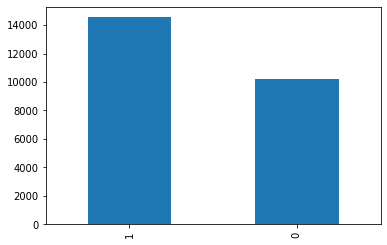

In [22]:
pd.value_counts(prescriber_df['Opioid.Prescriber']).plot.bar()

In [25]:
name = opioids_df['Drug Name']

new_name = name.apply(lambda x:re.sub("\ |-",".",str(x)))
columns = prescriber_df.columns
left_variables = set(columns).intersection(set(new_name))
kept_variables = []
for col in columns:
    if col not in left_variables:
        kept_variables.append(col)

In [26]:
full_df = prescriber_df[kept_variables]
print(full_df.shape)

(24761, 245)


In [27]:
full_df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,...,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,...,0,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,...,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


In [28]:
full_df = full_df.drop(full_df.columns[[0, 3]], axis = 1) 
full_df.head()

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,...,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,M,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,F,AL,General Surgery,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,...,0,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,F,NY,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,0,0,...,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,M,AZ,Internal Medicine,0,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,...,0,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,M,NV,Hematology/Oncology,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


# Split Data

In [29]:
train, test = train_test_split(full_df,test_size = 0.25,random_state = 1)
print(train.shape)
print(test.shape)

(18570, 243)
(6191, 243)


In [30]:
# Encode categorical variables to numerical values
categorical_columns = ['Gender','State','Specialty']

for col in categorical_columns:
    train[col] = pd.factorize(train[col], sort = True)[0]
    test[col] = pd.factorize(test[col],sort = True)[0]

In [31]:
features = train.iloc[:,1:242] 
features.head()

,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,...,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
18519,15,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5733,39,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3821,32,7,0,0,0,0,0,0,0,19,0,127,0,0,0,0,0,135,0,0,0,0,0,16,0,0,0,0,0,0,0,0,20,0,0,0,0,54,0,0,...,0,0,0,68,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82,39,27,0,0
4365,6,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10350,36,20,0,0,0,0,25,27,48,0,0,190,12,18,0,0,66,170,17,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,12,...,0,0,32,181,0,17,12,0,12,0,0,25,68,21,0,0,0,0,0,21,0,0,23,0,27,0,0,21,0,31,0,0,16,0,0,59,0,19,0,32


# Machine Learning Techniques

## Train - With Gender

In [32]:
# With 'Gender' included.
features = train.iloc[:,0:242] 

# Set target variables
target = train['Opioid.Prescriber']
Name = []
Accuracy = []

# our models
model1 = LogisticRegression(random_state = 24,C = 0.000000001,solver = 'liblinear',max_iter = 200)
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators = 200,random_state = 24)
model4 = GradientBoostingClassifier(n_estimators = 200)
model5 = KNeighborsClassifier()
model6 = DecisionTreeClassifier()
model7 = LinearDiscriminantAnalysis()
model8 = BaggingClassifier()
model9 = QuadraticDiscriminantAnalysis()
model11 = AdaBoostClassifier()
Ensembled_model = VotingClassifier(estimators = [('lr', model1), ('gn', model2), ('rf', model3),('gb',model4),('kn',model5),('dt',model6),('lda',model7), ('bc',model8),
                                                 ('qda',model9),('abc',model11)], voting = 'hard')
for model, label in zip([ model11,model7,model9,model6,model3,model5,model4,model8,Ensembled_model],
                        ['Ada Boost Classifier','LDA', 'QDA', 'Decision Tree','Random Forest', 'KNN', 'Gradient Boosting','Bagging Classifier', 'Ensemble']):
    scores = cross_val_score(model, features, target, cv = 5, scoring = 'accuracy')
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    word0= "Model(%s)" % (label)
    word1= "Mean Accuracy %f"% (scores.mean())
    print('{:<21}  {:<21} '.format(word0, word1))

Model(Ada Boost Classifier)  Mean Accuracy 0.789876 
Model(LDA)             Mean Accuracy 0.720032 
Model(QDA)             Mean Accuracy 0.638988 
Model(Decision Tree)   Mean Accuracy 0.775929 
Model(Random Forest)   Mean Accuracy 0.831556 
Model(KNN)             Mean Accuracy 0.779914 
Model(Gradient Boosting)  Mean Accuracy 0.826602 
Model(Bagging Classifier)  Mean Accuracy 0.807539 
Model(Ensemble)        Mean Accuracy 0.827787 


## Train - Without Gender

In [33]:
# Gender not included.
features=train.iloc[:,1:242] 
# Set target variable
target = train['Opioid.Prescriber']
Name = []
Accuracy = []
model1 = LogisticRegression(random_state = 24,C = 0.000000001,solver = 'liblinear',max_iter = 200)
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators = 200,random_state = 24)
model4 = GradientBoostingClassifier(n_estimators = 200)
model5 = KNeighborsClassifier()
model6 = DecisionTreeClassifier()
model7 = LinearDiscriminantAnalysis()
model8 = BaggingClassifier()
model9 = QuadraticDiscriminantAnalysis()
model11 = AdaBoostClassifier()
Ensembled_model = VotingClassifier(estimators = [('lr', model1), ('gn', model2), ('rf', model3),('gb',model4),('kn',model5),('dt',model6),('lda',model7), ('bc',model8),
                                                 ('qda',model9),('abc',model11)], voting = 'hard')
for model, label in zip([ model11,model7,model9,model6,model3,model5,model4,model8,Ensembled_model],
                        ['Ada Boost Classifier','LDA', 'QDA', 'Decision Tree','Random Forest', 'KNN', 'Gradient Boosting','Bagging Classifier', 'Ensemble']):
    scores = cross_val_score(model, features, target, cv = 5, scoring = 'accuracy')
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    word0= "Model(%s)" % (label)
    word1= "Mean Accuracy %f"% (scores.mean())
    print('{:<21}  {:<21} '.format(word0, word1))

Model(Ada Boost Classifier)  Mean Accuracy 0.782929 
Model(LDA)             Mean Accuracy 0.727087 
Model(QDA)             Mean Accuracy 0.639095 
Model(Decision Tree)   Mean Accuracy 0.776791 
Model(Random Forest)   Mean Accuracy 0.835649 
Model(KNN)             Mean Accuracy 0.780022 
Model(Gradient Boosting)  Mean Accuracy 0.828595 
Model(Bagging Classifier)  Mean Accuracy 0.812978 
Model(Ensemble)        Mean Accuracy 0.829672 


## 5 Best Models

In [34]:
Name_2 = []
Accuracy_2 = []
Ensembled_model_3 = VotingClassifier(estimators = [('rf', model3),('em',Ensembled_model)], voting = 'hard')
for model, label in zip([model3, model4,Ensembled_model_3, model8,model11], ['Random Forest', 'Gradient Boosting', 'Ensemble', 'Bagging Classifier', 'Ada Boost Classifier']):
    scores = cross_val_score(model, features, target, cv = 5, scoring = 'accuracy')
    Accuracy_2.append(scores.mean())
    Name_2.append(model.__class__.__name__)
    word0= "Model(%s)" % (label)
    word1= "Mean Accuracy %f"% (scores.mean())
    print('{:<21}  {:<21} '.format(word0, word1))

Model(Random Forest)   Mean Accuracy 0.835649 
Model(Gradient Boosting)  Mean Accuracy 0.828595 
Model(Ensemble)        Mean Accuracy 0.830264 
Model(Bagging Classifier)  Mean Accuracy 0.815186 
Model(Ada Boost Classifier)  Mean Accuracy 0.782929 


In [35]:
classifers = [model3,model4,model8]
out_sample_accuracy = []
Name_2 = []
for each in classifers:
    fit = each.fit(features,target)
    pred = fit.predict(test.iloc[:,1:242])
    accuracy = accuracy_score(test['Opioid.Prescriber'],pred)
    Name_2.append(each.__class__.__name__)
    out_sample_accuracy.append(accuracy)

## Metrics

### Confusion Matrix

In [36]:
y_actu = test['Opioid.Prescriber']
confusion_matrix(y_actu, pred)

array([[1873,  682],
       [ 970, 2666]])

In [37]:
sklearn.metrics.precision_recall_curve(y_actu, pred, pos_label = None, sample_weight = None)

(array([0.58730415, 0.7962963 , 1.        ]),
 array([1.        , 0.73322332, 0.        ]),
 array([0, 1]))

### Average Precision Score

In [38]:
average_precision = average_precision_score(y_actu, pred)

print('Mean Precision-Recall score: {0:0.2f}'.format(
      average_precision))

Mean Precision-Recall score: 0.74


### Precision Recall Curve

Text(0.5, 1.0, '2-class Precision-Recall curve: Avg. Precision=0.74')

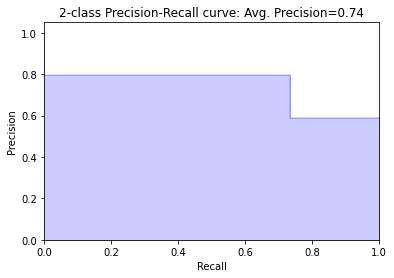

In [39]:
precision, recall, _ = precision_recall_curve(y_actu, pred)

plt.step(recall, precision, color = 'b', alpha = 0.2,
         where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha = 0.2,
                 color = 'b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Avg. Precision={0:0.2f}'.format(
          average_precision))

### Classification Report

In [40]:
print(sklearn.metrics.classification_report(y_actu, pred))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69      2555
           1       0.80      0.73      0.76      3636

    accuracy                           0.73      6191
   macro avg       0.73      0.73      0.73      6191
weighted avg       0.74      0.73      0.73      6191



### Confusion Matrix - Picturized

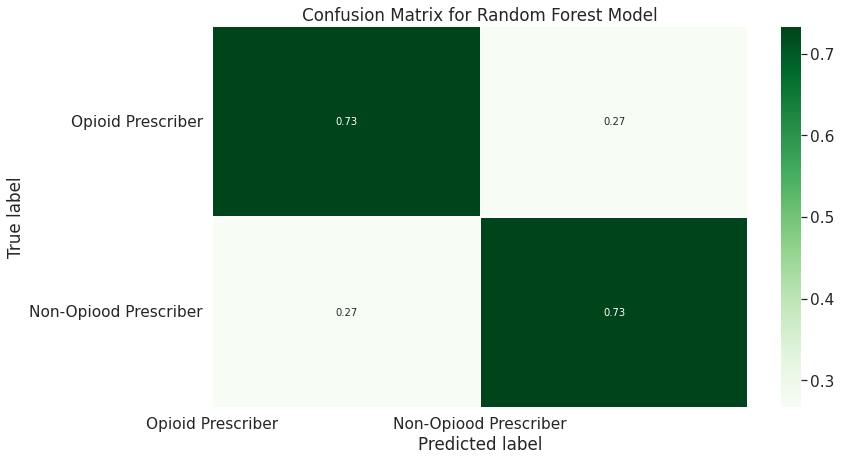

In [41]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_actu, pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(12,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Opioid Prescriber', 'Non-Opiood Prescriber']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Deep Learning Techniques

## Convert Data to Tensors

### Categorical Encoding

In [44]:
full_df

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,...,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,M,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,F,AL,General Surgery,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,...,0,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,F,NY,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,0,0,...,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,M,AZ,Internal Medicine,0,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,...,0,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,M,NV,Hematology/Oncology,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,F,WA,Family Practice,0,0,0,0,46,25,0,0,0,73,0,0,0,0,59,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,96,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,13,0,0,0,0,39,0,0,0,0,1
24996,F,MI,Internal Medicine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,20,0,0,0,0,1
24997,M,AZ,Emergency Medicine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24998,F,IN,Family Practice,0,0,0,0,0,0,16,0,0,32,12,0,0,0,20,91,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,12,0,...,0,19,39,0,0,0,0,0,0,11,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [50]:
X_cat = full_df[full_df.columns[:-1]] # features
y_cat = full_df[['Opioid.Prescriber']] # target
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size = 0.2,random_state = 1)

In [51]:
Categorical_columns = ['State', 'Specialty', 'Gender']

for col in Categorical_columns:
    X_train_cat[col] = pd.factorize(X_train_cat[col], sort = True)[0]
    X_test_cat[col] = pd.factorize(X_test_cat[col],sort = True)[0]

In [53]:
X_test_cat

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,...,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
11026,0,10,67,0,0,0,0,0,0,0,0,0,0,0,31,26,0,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18561,1,21,15,0,0,0,0,0,0,0,0,0,0,0,14,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12426,1,35,15,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8459,1,39,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6552,0,35,52,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14674,0,22,15,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12678,1,16,21,0,0,26,0,19,23,37,0,0,168,0,34,14,0,0,117,12,19,18,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,...,0,0,60,124,0,0,0,0,0,0,11,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,0,0,0,17
12243,1,5,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23658,1,28,15,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
X_train_cat = torch.from_numpy(X_train_cat.to_numpy()).float()
y_train_cat = torch.squeeze(torch.from_numpy(y_train_cat.to_numpy()).float())
X_test_cat = torch.from_numpy(X_test_cat.to_numpy()).float()
y_test_cat = torch.squeeze(torch.from_numpy(y_test_cat.to_numpy()).float())
print(X_train_cat.shape, y_train_cat.shape)
print(X_test_cat.shape, y_test_cat.shape)

torch.Size([19808, 242]) torch.Size([19808])
torch.Size([4953, 242]) torch.Size([4953])


### One-Hot Encoding

In [54]:
full_df_ohe = pd.get_dummies(full_df, columns=['Gender','Specialty'], drop_first=True)

In [55]:
X_ohe = full_df_ohe[full_df_ohe.columns[:-1]]
y_ohe = full_df_ohe[['Opioid.Prescriber']]
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size = 0.3,random_state = 1)

In [56]:
X_train_ohe["State"] = pd.factorize(X_train_ohe["State"], sort = True)[0]
X_test_ohe["State"] = pd.factorize(X_test_ohe["State"],sort = True)[0]

In [57]:
X_test_ohe

,State,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,...,Specialty_Oral Surgery (dentists only),Specialty_Orthopaedic Surgery,Specialty_Orthopedic Surgery,Specialty_Osteopathic Manipulative Medicine,Specialty_Otolaryngology,Specialty_Pain Management,Specialty_Pathology,Specialty_Pediatric Medicine,Specialty_Pharmacist,Specialty_Pharmacy Technician,Specialty_Physical Medicine and Rehabilitation,Specialty_Physical Therapist,Specialty_Physician Assistant,Specialty_Plastic Surgery,Specialty_Plastic and Reconstructive Surgery,Specialty_Podiatry,Specialty_Preferred Provider Organization,Specialty_Preventive Medicine,Specialty_Psychiatry,Specialty_Psychiatry & Neurology,Specialty_Psychologist,Specialty_Psychologist (billing independently),Specialty_Pulmonary Disease,Specialty_Radiation Oncology,Specialty_Registered Nurse,Specialty_Rehabilitation Agency,Specialty_Rheumatology,Specialty_Sleep Medicine,Specialty_Slide Preparation Facility,Specialty_Specialist,Specialty_Specialist/Technologist,Specialty_Sports Medicine,Specialty_Student in an Organized Health Care Education/Training Program,Specialty_Surgery,Specialty_Surgical Oncology,Specialty_Thoracic Surgery,Specialty_Thoracic Surgery (Cardiothoracic Vascular Surgery),Specialty_Unknown Physician Specialty Code,Specialty_Unknown Supplier/Provider,Specialty_Urology
11026,10,0,0,0,0,0,0,0,0,0,0,0,31,26,0,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18561,21,0,0,0,0,0,0,0,0,0,0,0,14,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12426,35,0,0,0,0,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8459,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6552,35,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17457,5,0,0,0,0,0,0,0,0,0,15,0,33,12,0,13,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8100,13,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11737,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22647,5,0,0,63,19,141,56,66,40,29,598,0,34,11,0,44,365,50,27,0,0,49,14,0,0,0,0,0,0,11,0,15,0,40,0,0,113,0,20,50,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
X_train_ohe = torch.from_numpy(X_train_ohe.to_numpy()).float()
y_train_ohe = torch.squeeze(torch.from_numpy(y_train_ohe.to_numpy()).float())
X_test_ohe = torch.from_numpy(X_test_ohe.to_numpy()).float()
y_test_ohe = torch.squeeze(torch.from_numpy(y_test_ohe.to_numpy()).float())
print(X_train_ohe.shape, y_train_ohe.shape)
print(X_test_ohe.shape, y_test_ohe.shape)

torch.Size([17332, 348]) torch.Size([17332])
torch.Size([7429, 348]) torch.Size([7429])


## Basic DNN

### Architecture

In [60]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 64)
    self.fc2 = nn.Linear(64, 8)
    self.fc3 = nn.Linear(8, 5)
    self.fc4 = nn.Linear(5, 3)
    self.fc5 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return torch.sigmoid(self.fc5(x))

In [69]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [70]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

### Training with Categorical Encoding

In [65]:
net_cat = Net(X_cat.shape[1])
n_features_cat = X_cat.shape[1]

In [66]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_cat.parameters(), lr=0.001)

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train_cat = X_train_cat.to(device)
y_train_cat = y_train_cat.to(device)
X_test_cat = X_test_cat.to(device)
y_test_cat = y_test_cat.to(device)
net_cat = net_cat.to(device)
criterion = criterion.to(device)

In [68]:
net_cat

Net(
  (fc1): Linear(in_features=242, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=3, bias=True)
  (fc5): Linear(in_features=3, out_features=1, bias=True)
)

In [71]:
for epoch in range(10000):
    y_pred_cat = net_cat(X_train_cat)
    y_pred_cat = torch.squeeze(y_pred_cat)
    train_loss = criterion(y_pred_cat, y_train_cat)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train_cat, y_pred_cat)
      y_test_pred_cat = net_cat(X_test_cat)
      y_test_pred_cat = torch.squeeze(y_test_pred_cat)
      test_loss = criterion(y_test_pred_cat, y_test_cat)
      test_acc = calculate_accuracy(y_test_cat, y_test_pred_cat)
      print(f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 1.098, accuracy: 0.417
Test  set - loss: 1.08, accuracy: 0.422

epoch 100
Train set - loss: 0.576, accuracy: 0.781
Test  set - loss: 0.597, accuracy: 0.767

epoch 200
Train set - loss: 0.498, accuracy: 0.85
Test  set - loss: 0.571, accuracy: 0.811

epoch 300
Train set - loss: 0.444, accuracy: 0.874
Test  set - loss: 0.6, accuracy: 0.815

epoch 400
Train set - loss: 0.281, accuracy: 0.891
Test  set - loss: 0.571, accuracy: 0.818

epoch 500
Train set - loss: 0.257, accuracy: 0.898
Test  set - loss: 0.672, accuracy: 0.816

epoch 600
Train set - loss: 0.215, accuracy: 0.915
Test  set - loss: 0.781, accuracy: 0.809

epoch 700
Train set - loss: 0.193, accuracy: 0.924
Test  set - loss: 0.904, accuracy: 0.803

epoch 800
Train set - loss: 0.174, accuracy: 0.931
Test  set - loss: 1.042, accuracy: 0.801

epoch 900
Train set - loss: 0.166, accuracy: 0.934
Test  set - loss: 1.116, accuracy: 0.801

epoch 1000
Train set - loss: 0.157, accuracy: 0.938
Test  set - loss: 1.25, 

### Evaluation with Categorical Encoding

In [72]:
MODEL_PATH_CAT = 'model_cat.pth'
torch.save(net_cat, MODEL_PATH_CAT)
net_cat = torch.load(MODEL_PATH_CAT)

In [73]:
classes = ['Not Opioid Prescriber', 'Opioid Prescriber']
y_pred_cat = net_cat(X_test_cat)
y_pred_cat = y_pred_cat.ge(.5).view(-1).cpu()
y_test_cat = y_test_cat.cpu()
print(classification_report(y_test_cat, y_pred_cat, target_names=classes))

                       precision    recall  f1-score   support

Not Opioid Prescriber       0.73      0.76      0.75      2051
    Opioid Prescriber       0.82      0.81      0.82      2902

             accuracy                           0.79      4953
            macro avg       0.78      0.78      0.78      4953
         weighted avg       0.79      0.79      0.79      4953



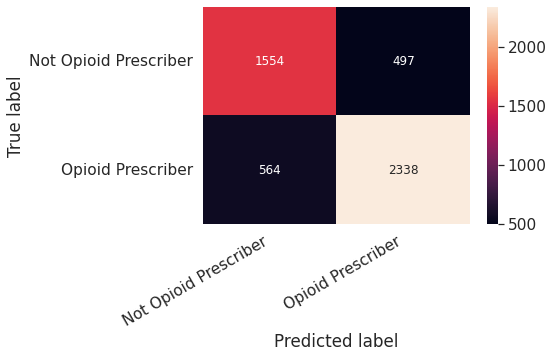

In [74]:
cm_cat = confusion_matrix(y_test_cat, y_pred_cat)
df_cm_cat = pd.DataFrame(cm_cat, index=classes, columns=classes)
hmap = sns.heatmap(df_cm_cat, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Training with One-Hot Encoding

In [75]:
net_ohe = Net(X_ohe.shape[1])
n_features_ohe = X_ohe.shape[1]

In [76]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net_ohe.parameters(), lr=0.001)

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train_ohe = X_train_ohe.to(device)
y_train_ohe = y_train_ohe.to(device)
X_test_ohe = X_test_ohe.to(device)
y_test_ohe = y_test_ohe.to(device)
net_ohe = net_ohe.to(device)
criterion = criterion.to(device)

In [78]:
net_ohe

Net(
  (fc1): Linear(in_features=348, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=3, bias=True)
  (fc5): Linear(in_features=3, out_features=1, bias=True)
)

In [79]:
for epoch in range(10000):
    y_pred_ohe = net_ohe(X_train_ohe)
    y_pred_ohe = torch.squeeze(y_pred_ohe)
    train_loss = criterion(y_pred_ohe, y_train_ohe)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train_ohe, y_pred_ohe)
      y_test_pred_ohe = net_ohe(X_test_ohe)
      y_test_pred_ohe = torch.squeeze(y_test_pred_ohe)
      test_loss = criterion(y_test_pred_ohe, y_test_ohe)
      test_acc = calculate_accuracy(y_test_ohe, y_test_pred_ohe)
      print(f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 0.762, accuracy: 0.414
Test  set - loss: 0.764, accuracy: 0.409

epoch 100
Train set - loss: 0.634, accuracy: 0.414
Test  set - loss: 0.696, accuracy: 0.409

epoch 200
Train set - loss: 0.504, accuracy: 0.414
Test  set - loss: 0.693, accuracy: 0.409

epoch 300
Train set - loss: 0.458, accuracy: 0.414
Test  set - loss: 0.717, accuracy: 0.409

epoch 400
Train set - loss: 0.424, accuracy: 0.414
Test  set - loss: 0.72, accuracy: 0.409

epoch 500
Train set - loss: 0.408, accuracy: 0.97
Test  set - loss: 0.643, accuracy: 0.922

epoch 600
Train set - loss: 0.367, accuracy: 0.991
Test  set - loss: 0.72, accuracy: 0.935

epoch 700
Train set - loss: 0.343, accuracy: 0.991
Test  set - loss: 0.756, accuracy: 0.93

epoch 800
Train set - loss: 0.321, accuracy: 0.991
Test  set - loss: 0.755, accuracy: 0.929

epoch 900
Train set - loss: 0.301, accuracy: 0.991
Test  set - loss: 0.741, accuracy: 0.931

epoch 1000
Train set - loss: 0.282, accuracy: 0.991
Test  set - loss: 0.718,

### Evaluation with One-Hot Encoding

In [80]:
MODEL_PATH_OHE = 'model_ohe.pth'
torch.save(net_ohe, MODEL_PATH_OHE)
net_ohe = torch.load(MODEL_PATH_OHE)

In [81]:
classes = ['Not Opioid Prescriber', 'Opioid Prescriber']
y_pred_ohe = net_ohe(X_test_ohe)
y_pred_ohe = y_pred_ohe.ge(.5).view(-1).cpu()
y_test_ohe = y_test_ohe.cpu()
print(classification_report(y_test_ohe, y_pred_ohe, target_names=classes))

                       precision    recall  f1-score   support

Not Opioid Prescriber       0.94      0.96      0.95      3042
    Opioid Prescriber       0.97      0.96      0.97      4387

             accuracy                           0.96      7429
            macro avg       0.96      0.96      0.96      7429
         weighted avg       0.96      0.96      0.96      7429



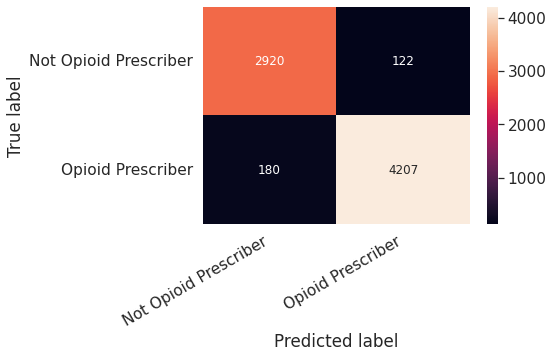

In [82]:
cm_ohe = confusion_matrix(y_test_ohe, y_pred_ohe)
df_cm_ohe = pd.DataFrame(cm_ohe, index=classes, columns=classes)
hmap = sns.heatmap(df_cm_ohe, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

## DNN Model with dropout layers in PyTorch

In [83]:
EPOCHS = 100
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [108]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

### Categorical Encoding DataLoaders

In [93]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size = 0.2,random_state = 1)
Categorical_columns = ['State', 'Specialty', 'Gender']

for col in Categorical_columns:
    X_train_cat[col] = pd.factorize(X_train_cat[col], sort = True)[0]
    X_test_cat[col] = pd.factorize(X_test_cat[col],sort = True)[0]

In [94]:
X_train_cat = X_train_cat.to_numpy()
y_train_cat = y_train_cat.to_numpy()
X_test_cat = X_test_cat.to_numpy()
y_test_cat = y_test_cat.to_numpy()

In [114]:
train_data_cat = TrainData(torch.FloatTensor(X_train_cat), 
                       torch.FloatTensor(y_train_cat))

test_data_cat = TestData(torch.FloatTensor(X_test_cat))

In [115]:
train_loader = DataLoader(dataset=train_data_cat, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_data_cat, batch_size=1)

### Architecture

In [100]:
class DNN_Model_2(nn.Module):
    def __init__(self, n_features):
      super(DNN_Model_2, self).__init__()
      self.layer_1 = nn.Linear(n_features, 128) 
      self.layer_2 = nn.Linear(128, 64)
      self.layer_out = nn.Linear(64, 1) 
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=0.1)
      self.batchnorm1 = nn.BatchNorm1d(128)
      self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
      x = self.relu(self.layer_1(inputs))
      x = self.batchnorm1(x)
      x = self.dropout(x)
      x = self.relu(self.layer_2(x))
      x = self.batchnorm2(x)
      x = self.dropout(x)
      x = self.layer_out(x)
        
      return x

In [103]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [101]:
n_features_cat = X_train_cat.shape[1]

In [102]:
model_cat = DNN_Model_2(n_features_cat)
model_cat.to(device)
print(model_cat)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_cat.parameters(), lr=LEARNING_RATE)

DNN_Model_2(
  (layer_1): Linear(in_features=242, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Training with Categorical Encoding

In [116]:
model_cat.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0

    test_loss = 0
    test_acc = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model_cat(X_batch)
        
        loss = criterion(y_pred.unsqueeze(-1), y_batch.unsqueeze(1))
        acc = binary_acc(y_pred.unsqueeze(-1), y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.14723 | Acc: 93.276
Epoch 002: | Loss: 0.14467 | Acc: 93.417
Epoch 003: | Loss: 0.14323 | Acc: 93.487
Epoch 004: | Loss: 0.14349 | Acc: 93.312
Epoch 005: | Loss: 0.14011 | Acc: 93.563
Epoch 006: | Loss: 0.14303 | Acc: 93.367
Epoch 007: | Loss: 0.14220 | Acc: 93.543
Epoch 008: | Loss: 0.14088 | Acc: 93.658
Epoch 009: | Loss: 0.14195 | Acc: 93.744
Epoch 010: | Loss: 0.14841 | Acc: 93.276
Epoch 011: | Loss: 0.14155 | Acc: 93.673
Epoch 012: | Loss: 0.14236 | Acc: 93.754
Epoch 013: | Loss: 0.13826 | Acc: 93.789
Epoch 014: | Loss: 0.13398 | Acc: 93.945
Epoch 015: | Loss: 0.14219 | Acc: 93.457
Epoch 016: | Loss: 0.13830 | Acc: 93.844
Epoch 017: | Loss: 0.13991 | Acc: 93.759
Epoch 018: | Loss: 0.14187 | Acc: 93.558
Epoch 019: | Loss: 0.13971 | Acc: 93.804
Epoch 020: | Loss: 0.13720 | Acc: 93.799
Epoch 021: | Loss: 0.14144 | Acc: 93.467
Epoch 022: | Loss: 0.14243 | Acc: 93.477
Epoch 023: | Loss: 0.14676 | Acc: 93.432
Epoch 024: | Loss: 0.13825 | Acc: 93.889
Epoch 025: | Los

### Evaluation with Categorical Encoding

In [117]:
y_pred_list_cat = []
model_cat.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred_cat = model_cat(X_batch)
        y_test_pred_cat = torch.sigmoid(y_test_pred_cat)
        y_pred_tag_cat = torch.round(y_test_pred_cat)
        y_pred_list_cat.append(y_pred_tag_cat.cpu().numpy())

y_pred_list_cat = [a.squeeze().tolist() for a in y_pred_list_cat]

In [118]:
cm_dnn_simple_cat = confusion_matrix(y_test_cat, y_pred_list_cat)
print(cm_dnn_simple_cat)

[[1570  481]
 [ 495 2407]]


In [119]:
classes = ['Not Opioid Prescriber', 'Opioid Prescriber']
print(classification_report(y_test_cat, y_pred_list_cat, target_names=classes))

                       precision    recall  f1-score   support

Not Opioid Prescriber       0.76      0.77      0.76      2051
    Opioid Prescriber       0.83      0.83      0.83      2902

             accuracy                           0.80      4953
            macro avg       0.80      0.80      0.80      4953
         weighted avg       0.80      0.80      0.80      4953



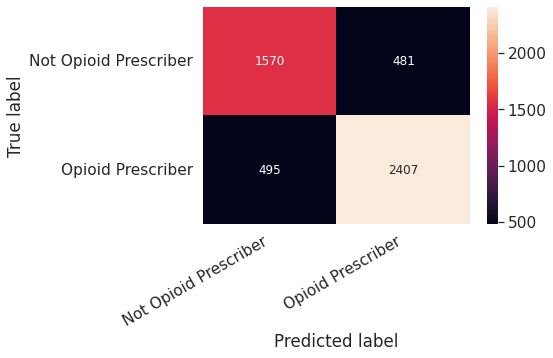

In [120]:
df_cm_dnn_simple_cat = pd.DataFrame(cm_dnn_simple_cat, index=classes, columns=classes)
hmap = sns.heatmap(df_cm_dnn_simple_cat, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### One-Hot Encoding DataLoaders

In [121]:
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size = 0.3,random_state = 1)
X_train_ohe["State"] = pd.factorize(X_train_ohe["State"], sort = True)[0]
X_test_ohe["State"] = pd.factorize(X_test_ohe["State"],sort = True)[0]

In [122]:
X_train_ohe = X_train_ohe.to_numpy()
y_train_ohe = y_train_ohe.to_numpy()
X_test_ohe = X_test_ohe.to_numpy()
y_test_ohe = y_test_ohe.to_numpy()

In [123]:
train_data_ohe = TrainData(torch.FloatTensor(X_train_ohe), 
                       torch.FloatTensor(y_train_ohe))

test_data_ohe = TestData(torch.FloatTensor(X_test_ohe))

In [124]:
train_loader = DataLoader(dataset=train_data_ohe, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_data_ohe, batch_size=1)

In [125]:
n_features_ohe = X_train_ohe.shape[1]

In [126]:
model_ohe = DNN_Model_2(n_features_ohe)
model_ohe.to(device)
print(model_ohe)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ohe.parameters(), lr=LEARNING_RATE)

DNN_Model_2(
  (layer_1): Linear(in_features=348, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Training with One-Hot Encoding

In [127]:
model_ohe.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0

    test_loss = 0
    test_acc = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model_ohe(X_batch)
        
        loss = criterion(y_pred.unsqueeze(-1), y_batch.unsqueeze(1))
        acc = binary_acc(y_pred.unsqueeze(-1), y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.44296 | Acc: 78.695
Epoch 002: | Loss: 0.24102 | Acc: 90.678
Epoch 003: | Loss: 0.15372 | Acc: 93.960
Epoch 004: | Loss: 0.11951 | Acc: 95.598
Epoch 005: | Loss: 0.09676 | Acc: 96.253
Epoch 006: | Loss: 0.08353 | Acc: 96.816
Epoch 007: | Loss: 0.06924 | Acc: 97.270
Epoch 008: | Loss: 0.06822 | Acc: 97.397
Epoch 009: | Loss: 0.05848 | Acc: 97.822
Epoch 010: | Loss: 0.05553 | Acc: 97.822
Epoch 011: | Loss: 0.05232 | Acc: 97.937
Epoch 012: | Loss: 0.04631 | Acc: 98.201
Epoch 013: | Loss: 0.04710 | Acc: 98.190
Epoch 014: | Loss: 0.04718 | Acc: 98.236
Epoch 015: | Loss: 0.03928 | Acc: 98.569
Epoch 016: | Loss: 0.03867 | Acc: 98.546
Epoch 017: | Loss: 0.03812 | Acc: 98.477
Epoch 018: | Loss: 0.03104 | Acc: 98.828
Epoch 019: | Loss: 0.03336 | Acc: 98.787
Epoch 020: | Loss: 0.02596 | Acc: 99.011
Epoch 021: | Loss: 0.03065 | Acc: 98.856
Epoch 022: | Loss: 0.02711 | Acc: 99.029
Epoch 023: | Loss: 0.02433 | Acc: 99.121
Epoch 024: | Loss: 0.02316 | Acc: 99.190
Epoch 025: | Los

### Evaluation with One-Hot Encoding

In [128]:
y_pred_list_ohe = []
model_ohe.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred_ohe = model_ohe(X_batch)
        y_test_pred_ohe = torch.sigmoid(y_test_pred_ohe)
        y_pred_tag_ohe = torch.round(y_test_pred_ohe)
        y_pred_list_ohe.append(y_pred_tag_ohe.cpu().numpy())

y_pred_list_ohe = [a.squeeze().tolist() for a in y_pred_list_ohe]

In [129]:
cm_dnn_simple_ohe = confusion_matrix(y_test_ohe, y_pred_list_ohe)
print(cm_dnn_simple_ohe)

[[2986   56]
 [  77 4310]]


In [130]:
classes = ['Not Opioid Prescriber', 'Opioid Prescriber']
print(classification_report(y_test_ohe, y_pred_list_ohe, target_names=classes))

                       precision    recall  f1-score   support

Not Opioid Prescriber       0.97      0.98      0.98      3042
    Opioid Prescriber       0.99      0.98      0.98      4387

             accuracy                           0.98      7429
            macro avg       0.98      0.98      0.98      7429
         weighted avg       0.98      0.98      0.98      7429



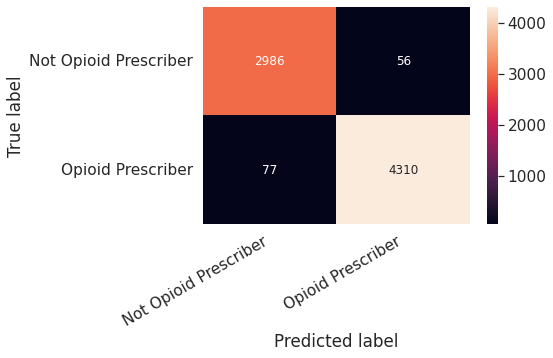

In [131]:
df_cm_dnn_simple_ohe = pd.DataFrame(cm_dnn_simple_ohe, index=classes, columns=classes)
hmap = sns.heatmap(df_cm_dnn_simple_ohe, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');